In [1]:
## This file provides starter code for extracting features from the xml files and
## for doing some learning.
##
## The basic set-up: 
## ----------------
## main() will run code to extract features, learn, and make predictions.
## 
## extract_feats() is called by main(), and it will iterate through the 
## train/test directories and parse each xml file into an xml.etree.ElementTree, 
## which is a standard python object used to represent an xml file in memory.
## (More information about xml.etree.ElementTree objects can be found here:
## http://docs.python.org/2/library/xml.etree.elementtree.html
## and here: http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/)
## It will then use a series of "feature-functions" that you will write/modify
## in order to extract dictionaries of features from each ElementTree object.
## Finally, it will produce an N x D sparse design matrix containing the union
## of the features contained in the dictionaries produced by your "feature-functions."
## This matrix can then be plugged into your learning algorithm.
##
## The learning and prediction parts of main() are largely left to you, though
## it does contain code that randomly picks class-specific weights and predicts
## the class with the weights that give the highest score. If your prediction
## algorithm involves class-specific weights, you should, of course, learn 
## these class-specific weights in a more intelligent way.
##
## Feature-functions:
## --------------------
## "feature-functions" are functions that take an ElementTree object representing
## an xml file (which contains, among other things, the sequence of system calls a
## piece of potential malware has made), and returns a dictionary mapping feature names to 
## their respective numeric values. 
## For instance, a simple feature-function might map a system call history to the
## dictionary {'first_call-load_image': 1}. This is a boolean feature indicating
## whether the first system call made by the executable was 'load_image'. 
## Real-valued or count-based features can of course also be defined in this way. 
## Because this feature-function will be run over ElementTree objects for each 
## software execution history instance, we will have the (different)
## feature values of this feature for each history, and these values will make up 
## one of the columns in our final design matrix.
## Of course, multiple features can be defined within a single dictionary, and in
## the end all the dictionaries returned by feature functions (for a particular
## training example) will be unioned, so we can collect all the feature values 
## associated with that particular instance.
##
## Two example feature-functions, first_last_system_call_feats() and 
## system_call_count_feats(), are defined below.
## The first of these functions indicates what the first and last system-calls 
## made by an executable are, and the second records the total number of system
## calls made by an executable.
##
## What you need to do:
## --------------------
## 1. Write new feature-functions (or modify the example feature-functions) to
## extract useful features for this prediction task.
## 2. Implement an algorithm to learn from the design matrix produced, and to
## make predictions on unseen data. Naive code for these two steps is provided
## below, and marked by TODOs.
##
## Computational Caveat
## --------------------
## Because the biggest of any of the xml files is only around 35MB, the code below 
## will parse an entire xml file and store it in memory, compute features, and
## then get rid of it before parsing the next one. Storing the biggest of the files 
## in memory should require at most 200MB or so, which should be no problem for
## reasonably modern laptops. If this is too much, however, you can lower the
## memory requirement by using ElementTree.iterparse(), which does parsing in
## a streaming way. See http://eli.thegreenplace.net/2012/03/15/processing-xml-in-python-with-elementtree/
## for an example. 

In [2]:
import os
from collections import Counter
from queue import Queue
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
import util

D:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def extract_feats(ffs, direc="train", global_feat_dict=None):
    """
    arguments:
      ffs are a list of feature-functions.
      direc is a directory containing xml files (expected to be train or test).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.

    returns: 
      a sparse design matrix, a dict mapping features to column-numbers,
      a vector of target classes, and a list of system-call-history ids in order 
      of their rows in the design matrix.
      
      Note: the vector of target classes returned will contain the true indices of the
      target classes on the training data, but will contain only -1's on the test
      data
    """
    fds = [] # list of feature dicts
    classes = []
    ids = [] 
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)
        rowfd = {}
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # accumulate features
        [rowfd.update(ff(tree)) for ff in ffs]
        fds.append(rowfd)
        
    X,feat_dict = make_design_mat(fds,global_feat_dict)
    return X, feat_dict, np.array(classes), ids


def make_design_mat(fds, global_feat_dict=None):
    """
    arguments:
      fds is a list of feature dicts (one for each row).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that 
      the columns of the test matrix align correctly.
       
    returns: 
        a sparse NxD design matrix, where N == len(fds) and D is the number of
        the union of features defined in any of the fds 
    """
    if global_feat_dict is None:
        all_feats = set()
        [all_feats.update(fd.keys()) for fd in fds]
        feat_dict = dict([(feat, i) for i, feat in enumerate(sorted(all_feats))])
    else:
        feat_dict = global_feat_dict
        
    cols = []
    rows = []
    data = []        
    for i in range(len(fds)):
        temp_cols = []
        temp_data = []
        for feat,val in fds[i].items():
            try:
                # update temp_cols iff update temp_data
                temp_cols.append(feat_dict[feat])
                temp_data.append(val)
            except KeyError as ex:
                if global_feat_dict is not None:
                    pass  # new feature in test data; nbd
                else:
                    raise ex

        # all fd's features in the same row
        k = len(temp_cols)
        cols.extend(temp_cols)
        data.extend(temp_data)
        rows.extend([i]*k)

    assert len(cols) == len(rows) and len(rows) == len(data)
   

    X = sparse.csr_matrix((np.array(data),
                   (np.array(rows), np.array(cols))),
                   shape=(len(fds), len(feat_dict)))
    return X, feat_dict
    

In [4]:
## Here are two example feature-functions. They each take an xml.etree.ElementTree object, 
# (i.e., the result of parsing an xml file) and returns a dictionary mapping 
# feature-names to numeric values.
## TODO: modify these functions, and/or add new ones.
def first_last_system_call_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'first_call-x' to 1 if x was the first system call
      made, and 'last_call-y' to 1 if y was the last system call made. 
      (in other words, it returns a dictionary indicating what the first and 
      last system calls made by an executable were.)
    """
    c = Counter()
    in_all_section = False
    first = True # is this the first system call
    last_call = None # keep track of last call we've seen
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            if first:
                c["first_call-"+el.tag] = 1
                first = False
            last_call = el.tag  # update last call seen
            
    # finally, mark last call seen
    c["last_call-"+last_call] = 1
    return c

def system_call_count_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'num_system_calls' to the number of system_calls
      made by an executable (summed over all processes)
    """
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c['num_system_calls'] += 1
    return c

def sys_call_count_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping el.tag to the number of times each system call 
      is made by an executable (summed over all processes)
    """
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c[el.tag] += 1
    return c

def n_gram_sys_call_count_feats(tree):
    dictionary = Counter()
    ns = range(2,12)
    for n in ns:
        c = Counter()
        in_all_section = False
        q = Queue(maxsize = n - 1)
        total = 0
        for el in tree.iter():
            # ignore everything outside the "all_section" element
            if el.tag == "all_section" and not in_all_section:
                in_all_section = True
            elif el.tag == "all_section" and in_all_section:
                in_all_section = False
            elif in_all_section and not q.full():
                q.put(el.tag)
            elif in_all_section:
                key = "-".join([str(elt) for elt in list(q.queue)]) + "-" + el.tag
                c[key] += 1
                total += 1
                q.get()
                q.put(el.tag)
        c = {k: v / total for k, v in c.items()}
        dictionary.update(c)
    return dictionary

def naive_bayes(X_train, t_train, X_test, global_feat_dict, test_features_dict, lamb_param):
    sums = np.zeros(len(util.malware_classes))

    for i in range(X_train.shape[0]):
        sums[t_train[i]] += np.sum(X_train[i])
    
    prior = [3.69,1.62,1.2,1.03,1.33,1.26,1.72,1.33,52.14,.68,17.56,1.04,12.18,1.91,1.3]
    
    scores = np.zeros((X_test.shape[0], len(util.malware_classes)))
    for i in range(X_test.shape[0]):
        for j in range(X_test.shape[1]):
            for k in range(len(util.malware_classes)):
                scores[i][k] += np.log((X_test[(i,j)] + lamb_param) / (sums[k] + len(test_features_dict) * lamb_param))

    scores = scores.T
    for k in range(len(scores)):
        scores[k] += np.log(prior[k] / 100) * 110
    scores = scores.T

    preds = np.argmax(scores, axis = 1)
    print(preds[:30])
    print(scores[:30])
    print(preds[600:])

    return preds

def acc(preds, t_validate):
    return np.sum(preds == np.array(t_validate)) / len(preds)

In [5]:
## The following function does the feature extraction, learning, and prediction

train_dir = "train"
test_dir = "test"
outputfile = "sample_predictions.csv"  # feel free to change this or take it as an argument

# TODO put the names of the feature functions you've defined above in this list
ffs = [n_gram_sys_call_count_feats]

# extract features
print ("extracting training features...")
X_train,global_feat_dict,t_train,train_ids = extract_feats(ffs, train_dir)
print ("done extracting training features")
print ()

extracting training features...
done extracting training features



In [15]:
# TODO train here, and learn your classification parameters
print ("learning...")
# learned_W = np.random.random((len(global_feat_dict),len(util.malware_classes)))
split = 2300
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
clf = RandomForestClassifier()
clf.fit(X_train[s[:split]], t_train[s[:split]])
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X_train)
new_clf = RandomForestClassifier()
new_clf.fit(X_new[s[:split]], t_train[s[:split]])
print ("done learning")
print ()

learning...
done learning



In [16]:
preds = clf.predict(X_train[s[split:]])
print (acc(preds, t_train[s[split:]]))
preds = new_clf.predict(X_new[s[split:]])
print (acc(preds, t_train[s[split:]]))

0.8676844783715013
0.8893129770992366


In [17]:
print (X_train.shape)
print (X_new.shape)

(3086, 527740)
(3086, 1902)


In [8]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [9]:
model = Sequential()
model.add(Dense(8000, activation='relu', input_dim=X_new.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(14, activation='softmax'))

In [10]:
split = 2300
s = np.arange(X_new.shape[0])
np.random.shuffle(s)
onehot_train = tf.Session().run(tf.one_hot(t_train, 14))
onehot_train = np.asarray(onehot_train, dtype = int)

In [11]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
model_info = model.fit(X_new[s[:split]], onehot_train[s[:split]],
          epochs=25,
          batch_size=32, 
        validation_data = (X_new[s[split:]], onehot_train[s[split:]]))

Train on 2300 samples, validate on 786 samples
Epoch 1/40
2300/2300 [==============================] - 6s 3ms/step - loss: 1.1927 - acc: 0.6791 - val_loss: 0.8764 - val_acc: 0.7557
Epoch 2/40
2300/2300 [==============================] - 5s 2ms/step - loss: 0.7682 - acc: 0.7726 - val_loss: 0.7414 - val_acc: 0.7697
Epoch 3/40
2300/2300 [==============================] - 5s 2ms/step - loss: 0.6248 - acc: 0.8022 - val_loss: 0.6504 - val_acc: 0.7952
Epoch 4/40
2300/2300 [==============================] - 5s 2ms/step - loss: 0.5386 - acc: 0.8313 - val_loss: 0.6038 - val_acc: 0.8168
Epoch 5/40
2300/2300 [==============================] - 5s 2ms/step - loss: 0.4642 - acc: 0.8557 - val_loss: 0.5367 - val_acc: 0.8384
Epoch 6/40
2300/2300 [==============================] - 5s 2ms/step - loss: 0.4209 - acc: 0.8683 - val_loss: 0.5227 - val_acc: 0.8422
Epoch 7/40
2300/2300 [==============================] - 5s 2ms/step - loss: 0.3834 - acc: 0.8743 - val_loss: 0.5367 - val_acc: 0.8346
Epoch 8/40
2300

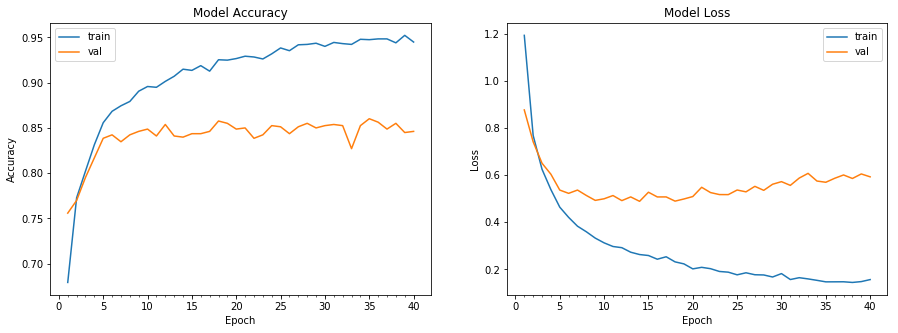

In [12]:

plot_model_history(model_info)

In [ ]:
NN_preds = model.predict(X_train[s[:split]])
acc(NN_preds.argmax(axis=1), t_train[s[:split]])


In [18]:
# get rid of training data and load test data
# del X_train
# del t_train
# del train_ids
print ("extracting test features...")
X_test,_,t_ignore,test_ids = extract_feats(ffs, test_dir, global_feat_dict=global_feat_dict)
print ("done extracting test features")
print ()
# preds_bayes = naive_bayes(X_train, t_train, X_test, global_feat_dict, test_features_dict, 1)
# split = 2300
# preds_bayes = naive_bayes(X_train[:split], t_train[:split], X_train[split:], global_feat_dict, global_feat_dict, 5)

extracting test features...
done extracting test features



In [19]:
X_new_test = model.transform(X_test)
preds = new_clf.predict(X_new_test)

In [20]:
# TODO make predictions on text data and write them out
print ("making predictions...")
# preds = np.argmax(X_train.dot(learned_W),axis=1)
# preds = clf.predict(X_test)
# print (acc(preds, t_train))
print ("done making predictions")
print ()

print ("writing predictions...")
util.write_predictions(preds, test_ids, outputfile)
print ("done!")

making predictions...
done making predictions

writing predictions...
done!
